<a href="https://colab.research.google.com/github/kaouther4habib/Deep-Autoencoder-based-Clustering-of-Histopathological-Images/blob/master/PFE_SIMPLE_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting up the env

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf 
from keras.models import Sequential
!pip install umap-learn
!pip install umap-learn[plot]
!pip install hdbscan
!pip install seaborn
!pip install streamlit
# !pip install pyngrok
import hdbscan
import pickle
import seaborn as sns
from keras.layers import Dense, Activation, Flatten, Input
from keras.models import Model
from keras import backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Umap Implementation

In [ ]:
import umap.umap_ as umap
# import umap.plot

def learn_manifold(x_data, umap_min_dist=0.00, umap_metric='euclidean', umap_dim=10, umap_neighbors=30):
    md = float(umap_min_dist)
    return umap.UMAP(
        random_state=0,
        metric=umap_metric,
        n_components=umap_dim,
        n_neighbors=umap_neighbors,
        min_dist=md).fit_transform(x_data)

# Loading data from drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Change the working directory
%cd /content/drive/MyDrive/data/datahisto/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data/datahisto


In [ ]:
ls

8863/  8867/  app.py                model_simp_ae.pb/  SIMPdbscan    umap
8864/  8913/  model_conv_ae.pb/     SIMPAE             SIMPhdbscan1
8865/  8914/  model_denoise_ae.pb/  SIMPagglo          SIMPKMEANS


In [ ]:
%cd /content/drive/MyDrive/data/datahisto



/content/drive/MyDrive/data/datahisto


In [ ]:
from glob import glob

# PATH_OF_DATA= '/content/drive/MyDrive/datahis2/8863/0'
imagePatches = glob('/content/drive/MyDrive/data/datahisto/**/**/*.png', recursive=True)

In [ ]:
k= len(imagePatches)
print(k)

19422


Preparing the data


In [ ]:
import cv2
import matplotlib.pyplot as plt
def __showImages__(imagePatches):
     img=cv2.imread(i)
     img_1=cv2.resize(img,(96,96))
    #  img_2=cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
    
     plt.imshow(img_1,cmap='binary')
     plt.show()



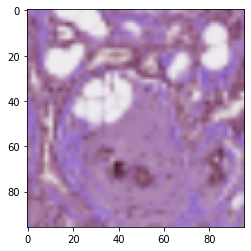

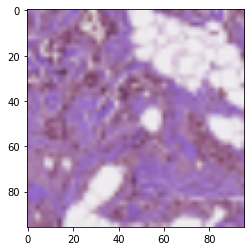

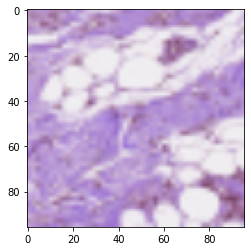

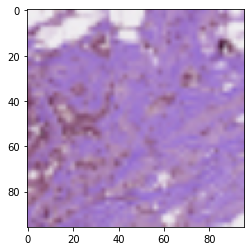

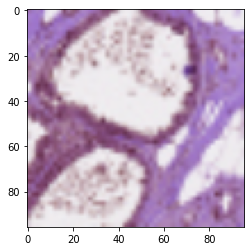

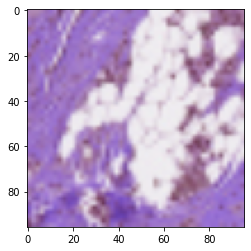

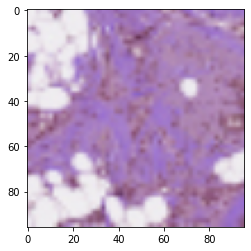

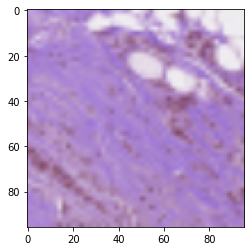

In [ ]:
for i in imagePatches[:8]:
   __showImages__(i)

# Preparing the data

In [ ]:
from PIL import Image
images=[]
labels=[]
for i in imagePatches[:19422]:
       if i.endswith('.png'):
         label=i[-5]
         img=cv2.imread(i)
         img_1=cv2.resize(img,(96,96))
         images.append(img_1)
         labels.append(label)


In [ ]:
x=np.stack(images)


In [ ]:
from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical
import tensorflow.keras.utils as conv_utils
y=to_categorical(labels)
print(y.shape)


(19422, 2)


In [ ]:
true_label= y.ravel()
print(true_label.shape)

true_label2 = np.resize(true_label,3885)
print(true_label2.shape)

(38844,)
(3885,)


Convert images to gray scale

In [ ]:
from skimage import data
from skimage.color import rgb2gray
X_train_grayscale = np.zeros(x.shape[:-1])
for i in range(x.shape[0]): 
     X_train_grayscale[i] = cv2.cvtColor(x[i], cv2.COLOR_BGR2GRAY) 


Split data to train and test

In [ ]:
 from sklearn.model_selection import train_test_split
 x_train,x_test,y_train,y_test=train_test_split(X_train_grayscale,y,random_state=0,test_size=0.2)


 x_train = x_train.astype('float32') /255.
 x_test = x_test.astype('float32') / 255.
 y_train = y_train.astype('float32')/255.
 y_test = y_test.astype('float32')/255.
 

 print(x_train.shape)
 print(x_test.shape)
 print(y_train.shape)
 print(y_test.shape)


(15537, 96, 96)
(3885, 96, 96)
(15537, 2)
(3885, 2)


# Building simple AE

In [ ]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(9216, activation='sigmoid'),
      layers.Reshape((96, 96))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 


In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Training the model

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
486/486 [==============================] - 15s 24ms/step - loss: 0.0239 - val_loss: 0.0209
Epoch 2/100
486/486 [==============================] - 9s 19ms/step - loss: 0.0196 - val_loss: 0.0190
Epoch 3/100
486/486 [==============================] - 9s 19ms/step - loss: 0.0178 - val_loss: 0.0169
Epoch 4/100
486/486 [==============================] - 9s 19ms/step - loss: 0.0164 - val_loss: 0.0158
Epoch 5/100
486/486 [==============================] - 9s 19ms/step - loss: 0.0153 - val_loss: 0.0148
Epoch 6/100
486/486 [==============================] - 11s 24ms/step - loss: 0.0145 - val_loss: 0.0141
Epoch 7/100
486/486 [==============================] - 10s 20ms/step - loss: 0.0139 - val_loss: 0.0137
Epoch 8/100
486/486 [==============================] - 9s 20ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 9/100
486/486 [==============================] - 10s 20ms/step - loss: 0.0127 - val_loss: 0.0126
Epoch 10/100
486/486 [==============================] - 9s 19ms/step - loss: 0

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

Testing and diplaying the results

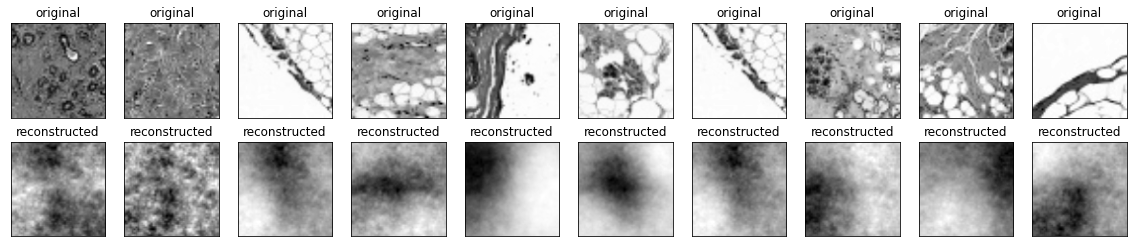

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# K-means clustering

In [ ]:
print(x_test.shape)
print(encoded_imgs.shape)
nsamples, nx = encoded_imgs.shape
X_encoded = encoded_imgs.reshape((nsamples,nx))
X_reduced = learn_manifold(X_encoded,umap_min_dist=0.00, umap_metric='euclidean', umap_neighbors=30)

(3885, 96, 96)
(3885, 64)


In [ ]:
print(X_reduced.shape)

(3885, 10)


Implementing the elbow method to determine the number of K


Text(0, 0.5, 'WCSS')

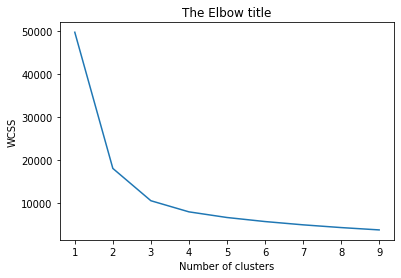

In [ ]:
from sklearn.cluster import KMeans

wcss=[]
for i in range(1,10):
  kmeans = KMeans(i)
  kmeans.fit(X_reduced)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,10)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

Implementing k-means with k=2

In [ ]:

k_encoded = KMeans(n_clusters=2)
label = k_encoded.fit_predict(X_reduced)


[0 1]


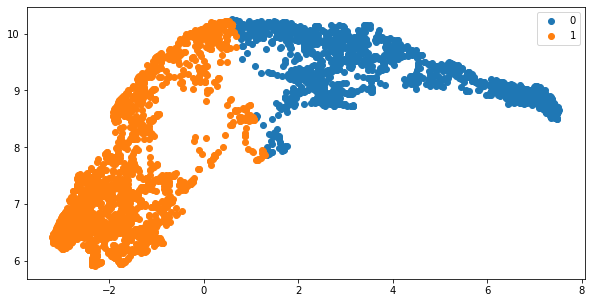

In [ ]:
u_labels = np.unique(label)
print(u_labels)
#plotting the results:
fig = plt.figure(figsize = (10, 5))
for i in u_labels:
  plt.scatter(X_reduced[label == i, 0], X_reduced[label == i, 1], label=i)
plt.legend()
plt.show(fig)

# Evaluation measures for K-means

 *Silhouette measure for kmeans*


In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

score = silhouette_score(X_reduced, k_encoded.labels_, metric='euclidean')
#
# Print the score
#
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.539


Visualising the silhouette score

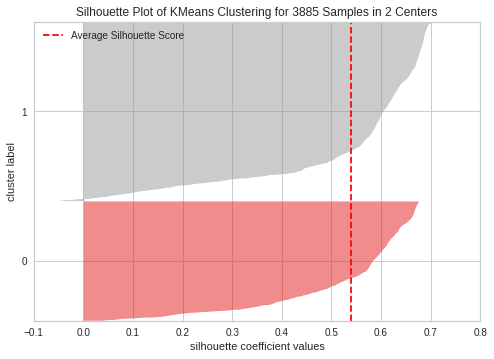

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

clf = KMeans(n_clusters=2)
vzr = SilhouetteVisualizer(clf)
vzr.fit(X_reduced)
vzr.poof()

In [ ]:
print(k_encoded.labels_.shape)

(3885,)


In [ ]:
pred_label = np.resize(k_encoded.labels_,3885)
print(pred_label.shape)

(3885,)


*Davis Bouldin measure*

In [ ]:
from sklearn.metrics import davies_bouldin_score


db_index = davies_bouldin_score(X_reduced, k_encoded.labels_)
print(db_index)

0.6845800839555253


In [ ]:
print(k_encoded.labels_.shape)

(3885,)


# Hierarchical Clustering

Implementing the algorithm

In [ ]:
from sklearn.cluster import AgglomerativeClustering


agg_cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg_cluster.fit_predict(X_reduced)
print(agg_cluster.labels_)

n_clusters_ = len(set(agg_cluster.labels_)) - (1 if -1 in agg_cluster.labels_ else 0)
print(n_clusters_)

[0 0 1 ... 0 0 0]
2


In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=agg_cluster.labels_, cmap='rainbow')

# DBSCAN Clusterig

Implementing the algorirthm

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np

clustering = DBSCAN(eps=1, min_samples=3)
dbscan= clustering.fit(X_reduced)
#Storing the labels formed by the DBSCAN
db_labels = dbscan.labels_
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print(n_clusters_)

plt.scatter(X_reduced[:, 0], X_reduced[:,1], c = db_labels, cmap= "plasma") # plotting the clusters
plt.show() # showing the plot



# HDBSCAN CLUSTERING

[HDBSCAN(min_cluster_size=50, prediction_data=True)]
2


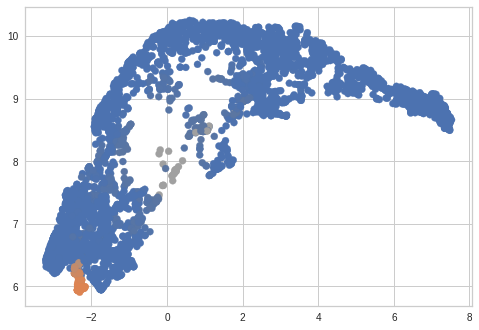

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=50,prediction_data=True).fit(X_reduced)
h_labels = np.unique(clusterer)
print(h_labels)

#Plotting the results
pal = sns.color_palette('deep', 9)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_,
                                                            clusterer.probabilities_)]
plt.scatter(X_reduced.T[0], X_reduced.T[1], c=colors);


n_clusters_ = len(set(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0)
print(n_clusters_)

# Mean shift clustering

Estimated clusters: [0 1]


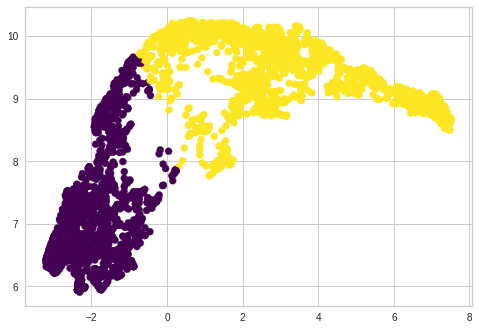

In [ ]:
from sklearn.cluster import MeanShift,estimate_bandwidth


ms = MeanShift()
ms.fit(X_reduced)
labels = ms.labels_
y_pred  = ms.predict(X_reduced)

shift_labels = np.unique(ms.labels_)
print("Estimated clusters:", shift_labels)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pred, cmap="viridis")

# colors = 10*['r.','g.','b.','c.','k.','y.','m.']
# for i in range(len(X_reduced)):
#     plt.plot(X[i][0], X[i][1], colors[shift_labels[i]], markersize = 3)
# plt.scatter(cluster_centers[:,0],cluster_centers[:,1],
#            marker=".",color='k', s=20, linewidths = 5, zorder=10)
# plt.show()

#Plotting the results
# pal = sns.color_palette('deep', 10)
# colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_,   
#                                                             clusterer.probabilities_)]
# plt.scatter(X_reduced.T[0], X_reduced.T[1], c=colors);
# n_clusters_ = len(set(k_encoded.labels_)) - (1 if -1 in k_encoded.labels_ else 0)

# print('Number of clusters is: '+str(n_clusters_))

In [ ]:
# %%writefile app.py
# import streamlit as st
# PAGE_CONFIG = {"page_title":"StColab.io","page_icon":":smiley:","layout":"centered"}
# st.set_page_config(**PAGE_CONFIG)
# def main():
#   st.subheader("Clustering Based Autoencoder Models")
#   menu = ["Simple AE","Convolutional AE","Variational AE"]
#   choice = st.sidebar.selectbox('Autoencoder Type',menu)
#   menu2 = ["K-means","Hierarchical clustering","DBSCAN","HDSCAN","Mean shift"]
#   choice2 = st.sidebar.selectbox('Clustering Type',menu2)

#   if choice == 'Simple AE':
#    st.subheader("Simple Autoencoder")	
#   #  for i in imagePatches[:5]:
#   #    image = Image.open(i)

# if __name__ == '__main__':
# 	main()

In [ ]:
ls


In [ ]:
# !streamlit run app.py & npx localtunnel --port 8501

In [ ]:
# filename = 'SIMPAE'
# pickle.dump(autoencoder, open(filename, 'wb'))



In [ ]:
# filename1='umap'
# pickle.dump(learn_manifold,open(filename1,'wb'))

In [ ]:
# kmeans= 'SIMPKMEANS'
# pickle.dump(k_encoded,open(kmeans,'wb'))

In [ ]:
# dbscan_algo = "SIMPdbscan"
# pickle.dump(clustering,open(dbscan_algo,'wb'))

In [ ]:
# AgglomerativeClustering = "SIMPagglo"
# pickle.dump(agg_cluster,open(AgglomerativeClustering,'wb'))

In [ ]:
# score_silhouette = 'kmeans-silhouette'
# pickle.dump(score,open(score_silhouette,'wb'))

In [ ]:
# hdbscan = 'SIMPhdbscan1'
# pickle.dump(clusterer,open(hdbscan,'wb'))

In [ ]:
## save model
filepath = "/content/drive/MyDrive/data/datahisto/model_simp_ae.pb"
tf.keras.models.save_model(
    autoencoder,
    filepath,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

## load tensorflow model
# model = keras.models.load_model(save_path)

In [ ]:
localhost_save_option1 = tf.saved_model.SaveOptions(experimental_io_device="/job:localhost")
autoencoder.save(filepath, options=localhost_save_option1)